### questions 

- Currently running a exhaustive search on the scf machine 
- Whats going on with the residuals?
- How should we interpret them for what interaction terms we need and transformations or including a square of the parameter? 
- Is the time lag that we have sufficient? 

Here we are going to do new modeling for the new data set that rhiann and ashlynn completed. This is going to be making some models before we have finished running the ehxaustive search to see how it performs 

Make a baseline with the previous Spatial component and that is it!! Test it with the subsetted variables and do a training and test set to evaluate how well the model does, also compare it to this baselin that you have from just the spatial componet and that is it!! Plot the residuals also and look at it. Perhaps make code also to compute the Moran's I for the best model to see if there is a spatial componet in your model at all anymore.

In [2]:
import os 
import numpy as np
import pandas as pd 
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.formula.api import ols
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression

/Users/meera/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/meera/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


For modeling doesn't make sense to include year in the model... because saying its a continous variable but it's not. Thus in order to include Year we should have perhaps 10 different predictor variables that are categorical indicating 0 or 1 depending on if they should be included in the model or not. 

## Loading the data and removing NA 

In [25]:
# Navigating to csv file
os.chdir('/Users/meera/Documents/drugs/Data')
od = pd.read_csv('od_full.csv')

#for the modeling we have to drop the null values 
od_nonull = od[od['Overdose_Deaths'].notna()]
od_nonull = od_nonull.drop(['Pct_Majority_Income_to_Housing',
                            'Pct_Child_Free_Lunch', 'Premature_Deaths',
                            'Violent_Crime_Rate_per_100k', 'HIV_Rate_per_100k'], axis = 1)

#now we drop all the na values 
od_nonull = od_nonull.dropna(axis = 0)
od_nonull.isnull().sum()

Year                         0
FIPS                         0
County                       0
State                        0
Region                       0
Division                     0
Overdose_Deaths              0
Overdose_Pop                 0
Overdose_Rate_per_100k       0
Population                   0
Pct_Age<18                   0
Pct_Age>=65                  0
Pct_Black                    0
Pct_Native                   0
Pct_Asian                    0
Pct_Pacific_Islander         0
Pct_Hispanic                 0
Pct_Not_Prof_in_Eng          0
Pct_Female                   0
Pct_Rural                    0
Pct_Diabetes                 0
Potential_Years_Lost         0
Pct_Low_Weight_Births        0
Pct_Smokers                  0
Pct_Adults_Obsese            0
Pct_Excessive_Drinking       0
Pct_DUI_Deaths               0
Teen_Birth_Rate_per_100k     0
Pct_Uninsured                0
PrimCarePhys_per_100k        0
Pct_HS_Grad                  0
Pct_College_Edu              0
Pct_Chil

In [26]:
#taking the log transform of this variable for the modeling !! 
#Also it should be noted that we are not going to standardize our predictors just yet !

od_y = np.log(od_nonull['Overdose_Rate_per_100k'])

In [27]:
od_x = od_nonull[['Year',
       'Population', 'Pct_Age<18', 'Pct_Age>=65', 'Pct_Black', 'Pct_Native',
       'Pct_Asian', 'Pct_Pacific_Islander', 'Pct_Hispanic',
       'Pct_Not_Prof_in_Eng', 'Pct_Female', 'Pct_Rural', 'Pct_Diabetes',
       'Potential_Years_Lost', 'Pct_Low_Weight_Births', 'Pct_Smokers',
       'Pct_Adults_Obsese', 'Pct_Excessive_Drinking', 'Pct_DUI_Deaths',
       'Teen_Birth_Rate_per_100k', 'Pct_Uninsured', 'PrimCarePhys_per_100k',
       'Pct_HS_Grad', 'Pct_College_Edu', 'Pct_Children_in_Poverty',
       'Pct_Child_in_1ParentHH', 'Opioid_Disp_Rate_per_100k', 'Pct_Unemployed',
       'Pct_Poverty', 'Median_HHI', 'Jail_Pop', 'Urbanicity','Prev_Spatial_Max', 'Prev_Spatial_Mean']]

In [6]:
def compute_rmse(predictions, yvalues): 
    rmse = np.sqrt(np.sum(np.subtract(yvalues, predictions)**2)/len(yvalues))
    return rmse 

## Our baseline model ! 

In [7]:
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from sklearn.metrics import r2_score 

In [39]:
y, X = dmatrices("Overdose_Rate_per_100k ~ Prev_Spatial_Mean", 
                 data=od_nonull, return_type='dataframe')

In [40]:
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [41]:
#this is just with the spatial mean component 
mod = sm.OLS(y_train, x_train)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = od_y
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.403
Model:                                OLS   Adj. R-squared:                  0.403
Method:                     Least Squares   F-statistic:                     3798.
Date:                    Thu, 28 Apr 2022   Prob (F-statistic):               0.00
Time:                            15:31:48   Log-Likelihood:                -3218.9
No. Observations:                    5622   AIC:                             6442.
Df Residuals:                        5620   BIC:                             6455.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [42]:
y_test_pred = res.predict(x_test)
r_squared = r2_score(y_test, y_test_pred)
r_squared

0.3974460152894499

In [43]:
np.array(y_test_pred)

array([2.70075559, 2.77656847, 3.48536828, ..., 2.73431703, 2.86032038,
       2.74069343])

In [44]:
y_test = np.array(y_test).reshape(1875,1)
y_test_pred = np.array(y_test_pred).reshape(1875,1)
compute_rmse(y_test, y_test_pred)

0.4447552169623239

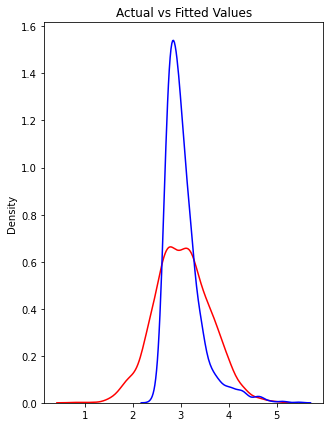

In [45]:
plt.figure(figsize=(5, 7))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_test_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [46]:
from sklearn import metrics 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))

Mean Absolute Error: 0.3491057417548485
Mean Squared Error: 0.1978072030152038


## Doing forward step-wise selection 

In [47]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

In [48]:
od_x.columns
od_x

,Year,Population,Pct_Age<18,Pct_Age>=65,Pct_Black,Pct_Native,Pct_Asian,Pct_Pacific_Islander,Pct_Hispanic,Pct_Not_Prof_in_Eng,...,Pct_Children_in_Poverty,Pct_Child_in_1ParentHH,Opioid_Disp_Rate_per_100k,Pct_Unemployed,Pct_Poverty,Median_HHI,Jail_Pop,Urbanicity,Prev_Spatial_Max,Prev_Spatial_Mean
1,2011,179878.0,23.100000,17.000000,10.000000,0.500000,0.600000,0.000000,3.300000,1.800000,...,15.1,28.900000,150000.0,9.0,13.4,50144.0,743.36,2.0,26.096714,16.138937
7,2011,114081.0,23.400000,15.000000,20.000000,0.400000,0.800000,0.100000,2.600000,1.500000,...,22.9,38.200000,176700.0,10.3,20.9,39060.0,504.25,2.0,17.944086,14.717519
21,2011,81778.0,23.300000,15.600000,1.700000,0.500000,0.200000,0.000000,4.400000,2.200000,...,19.7,25.600000,180600.0,9.5,18.2,39395.0,312.43,1.0,50.728854,27.746062
24,2011,69380.0,25.500000,14.300000,2.000000,0.800000,0.400000,0.100000,11.700000,5.900000,...,25.1,29.200000,100600.0,11.7,20.3,35487.0,204.54,1.0,14.544185,13.017568
26,2011,37434.0,23.000000,15.200000,32.100000,3.100000,0.300000,0.000000,1.500000,0.400000,...,31.7,41.300000,149000.0,10.7,25.5,32838.0,192.75,1.0,15.194356,12.847718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31391,2020,135693.0,21.903856,17.985452,1.243985,0.392798,1.459176,0.042744,3.220505,0.497790,...,4.9,21.036707,25100.0,5.6,5.1,81659.0,229.00,3.0,42.401287,20.457328
31392,2020,403072.0,21.508564,18.654235,1.590287,0.324012,3.886651,0.054581,4.786986,0.680531,...,4.8,18.233691,41100.0,5.6,4.2,92359.0,350.00,3.0,42.401287,22.396738
31395,2020,171020.0,20.515144,16.385218,2.170506,0.746112,3.045843,0.053210,4.200094,0.931389,...,11.6,30.599278,41000.0,5.4,8.7,64653.0,310.00,2.0,12.572169,11.874609
31396,2020,73055.0,21.556362,20.562590,0.880159,0.932174,2.003970,0.031483,3.092191,0.717323,...,13.2,28.558645,47400.0,6.7,9.4,54154.0,94.00,1.0,11.791410,11.791410


In [49]:
X_columns = od_x.columns
X = np.array(od_x).reshape(7497, 34)
y = np.array(od_y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [50]:
def compute_rmse(predictions, yvalues): 
    rmse = np.sqrt(np.sum(np.subtract(yvalues, predictions)**2)/len(yvalues))
    return rmse 

In [51]:
from sklearn.model_selection import KFold

In [52]:
kf = KFold(n_splits=2, random_state=0, shuffle=True)
for train_index, test_index in kf.split(od_nonull):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [53]:
train_rmse_list = []
test_rmse_list = []
best_features = []
lr = LinearRegression()

for i in range(1, 34):
    sfs = SequentialFeatureSelector(lr, n_features_to_select=i, 
                                    direction='forward', scoring='neg_mean_squared_error', 
                                    cv = 5)
    sfs.fit(X_train, y_train)

    best_cols = sfs.get_support()
    best_cols = [i for i, x in enumerate(best_cols) if x]
    best_cols = X_columns[best_cols].tolist()
    best_features.append(best_cols)

    X_subset = np.array(od_x[best_cols]).reshape(7497, len(best_cols))
    X_subtrain = X_subset[train_index]
    X_subtest = X_subset[test_index]
    
    lr.fit(X_subtrain, y_train)
    yhat_train = lr.predict(X_subtrain)
    train_rmse = compute_rmse(y_train, yhat_train)
    train_rmse_list.append(train_rmse)
    
    yhat_test = lr.predict(X_subtest)
    test_rmse = compute_rmse(y_test, yhat_test)
    test_rmse_list.append(test_rmse)

best_features_forwards = best_features.copy() 
score_board = pd.DataFrame(train_rmse_list, columns=['train_rmse'])
score_board['test_rmse'] = test_rmse_list
score_board.insert(0, 'n_features_to_select', range(1, 34))
score_board.insert(1, 'best_features', best_features)
score_board

,n_features_to_select,best_features,train_rmse,test_rmse
0,1,[Prev_Spatial_Mean],0.432524,0.433409
1,2,"[Potential_Years_Lost, Prev_Spatial_Mean]",0.402115,0.401817
2,3,"[Potential_Years_Lost, Pct_Uninsured, Prev_Spa...",0.384611,0.382464
3,4,"[Pct_Age>=65, Potential_Years_Lost, Pct_Uninsu...",0.374080,0.374737
4,5,"[Pct_Age>=65, Potential_Years_Lost, Pct_DUI_De...",0.370893,0.372787
5,6,"[Pct_Age<18, Pct_Age>=65, Potential_Years_Lost...",0.368572,0.369241
6,7,"[Pct_Age<18, Pct_Age>=65, Potential_Years_Lost...",0.366151,0.365660
7,8,"[Pct_Age<18, Pct_Age>=65, Potential_Years_Lost...",0.365255,0.364698
8,9,"[Pct_Age<18, Pct_Age>=65, Pct_Asian, Potential...",0.363968,0.364670
9,10,"[Pct_Age<18, Pct_Age>=65, Pct_Asian, Potential...",0.362846,0.363542


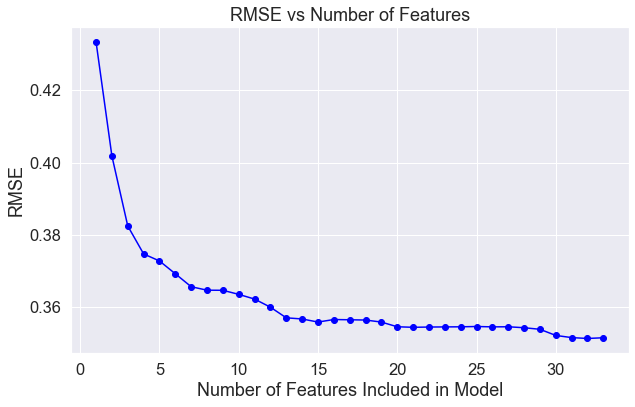

In [54]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(score_board['n_features_to_select'], score_board['test_rmse'], 
        color = 'blue', marker = 'o')
ax.set_xlabel('Number of Features Included in Model')
ax.set_ylabel('RMSE')
ax.set_title('RMSE vs Number of Features')
plt.show()

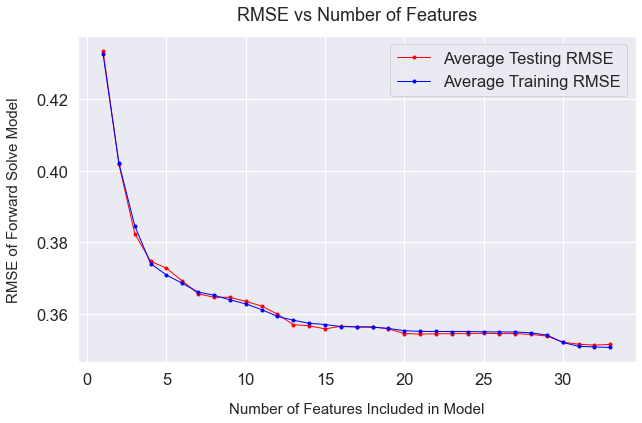

In [55]:
plt.figure(figsize=(10,6))
plt.plot(score_board['n_features_to_select'], score_board['test_rmse'], color="red", label="Average Testing RMSE", linewidth=1, marker='.')
plt.plot(score_board['n_features_to_select'], score_board['train_rmse'], color="blue", label="Average Training RMSE", linewidth=1, marker='.')
# plt.plot(optim_Lambda, best_test_rmse, marker='o', color='goldenrod', alpha=0.4, markersize = 15)
# plt.text(optim_Lambda, best_test_rmse-.04, 'Optimal Lambda: {:.4f}'.format(Lambda[14]), 
#          color='goldenrod')
plt.title("RMSE vs Number of Features", y=1.03)
plt.xlabel("Number of Features Included in Model", fontsize=15, labelpad=15)
plt.ylabel("RMSE of Forward Solve Model", fontsize=15, labelpad=15)
plt.legend()
plt.show()  

### Picking a number of 10 to see if does something

In [56]:
## From the elbow best features could be 10 ? 
best_features[10]

['Pct_Age<18',
 'Pct_Age>=65',
 'Pct_Black',
 'Pct_Asian',
 'Potential_Years_Lost',
 'Pct_Adults_Obsese',
 'Pct_DUI_Deaths',
 'Pct_Uninsured',
 'PrimCarePhys_per_100k',
 'Urbanicity',
 'Prev_Spatial_Mean']

In [34]:
od_nonull = od_nonull.rename(columns={'Pct_Age<18' : 'Pct_Age_18', 'Pct_Age>=65' : 'Pct_Age_65'})

In [61]:
y, X = dmatrices("Overdose_Rate_per_100k ~ Pct_Age_18 + Pct_Age_65 + Pct_Black + Pct_Asian + \
  Potential_Years_Lost + Pct_Adults_Obsese + Pct_DUI_Deaths + Pct_Uninsured +PrimCarePhys_per_100k + \
  Urbanicity + Prev_Spatial_Mean",
                 data=od_nonull, return_type='dataframe')

In [62]:
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [63]:
#this is just with the spatial mean component 
mod = sm.OLS(y_train, x_train)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = od_y
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.584
Model:                                OLS   Adj. R-squared:                  0.583
Method:                     Least Squares   F-statistic:                     714.9
Date:                    Thu, 28 Apr 2022   Prob (F-statistic):               0.00
Time:                            15:37:31   Log-Likelihood:                -2207.3
No. Observations:                    5622   AIC:                             4439.
Df Residuals:                        5610   BIC:                             4518.
Df Model:                              11                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [64]:
#this is the 
y_test_pred = res.predict(x_test)
r_squared = r2_score(y_test, y_test_pred)
r_squared

0.5799272839971448

In [67]:
y_test_pred = np.array(y_test_pred)
y_test = np.array(y_test).reshape(1875,1)
y_test_pred = np.array(y_test_pred).reshape(1875,1)
compute_rmse(y_test, y_test_pred)

0.37135160646854176

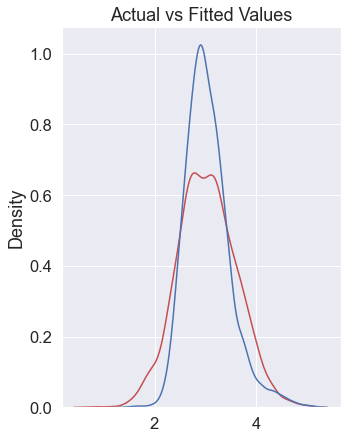

In [68]:
plt.figure(figsize=(5, 7))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_test_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

its better but still bad ! we must not do perhaps a backwards stepwise regression ...... could be better we are also getting values in our model that are not significant !! 

### This is now for backwards stepwise regression
here we are going to see how it performs because 

In [70]:
X_columns = od_x.columns
X = np.array(od_x).reshape(7497, 34)
y = np.array(od_y)

In [71]:
kf = KFold(n_splits=2, random_state=0, shuffle=True)
for train_index, test_index in kf.split(od_nonull):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [72]:
train_rmse_list = []
test_rmse_list = []
best_features = []
lr = LinearRegression()

for i in range(1, 34):
    sfs = SequentialFeatureSelector(lr, n_features_to_select=i, 
                                    direction='backward', scoring='neg_mean_squared_error', 
                                    cv = 5)
    sfs.fit(X_train, y_train)

    best_cols = sfs.get_support()
    best_cols = [i for i, x in enumerate(best_cols) if x]
    best_cols = X_columns[best_cols].tolist()
    best_features.append(best_cols)

    X_subset = np.array(od_x[best_cols]).reshape(7497, len(best_cols))
    X_subtrain = X_subset[train_index]
    X_subtest = X_subset[test_index]
    
    lr.fit(X_subtrain, y_train)
    yhat_train = lr.predict(X_subtrain)
    train_rmse = compute_rmse(y_train, yhat_train)
    train_rmse_list.append(train_rmse)
    
    yhat_test = lr.predict(X_subtest)
    test_rmse = compute_rmse(y_test, yhat_test)
    test_rmse_list.append(test_rmse)

best_features_forwards = best_features.copy() 
score_board = pd.DataFrame(train_rmse_list, columns=['train_rmse'])
score_board['test_rmse'] = test_rmse_list
score_board.insert(0, 'n_features_to_select', range(1, 34))
score_board.insert(1, 'best_features', best_features)
score_board

,n_features_to_select,best_features,train_rmse,test_rmse
0,1,[Prev_Spatial_Mean],0.432524,0.433409
1,2,"[Potential_Years_Lost, Prev_Spatial_Mean]",0.402115,0.401817
2,3,"[Pct_Age<18, Potential_Years_Lost, Prev_Spatia...",0.386541,0.386034
3,4,"[Year, Pct_Age<18, Potential_Years_Lost, Prev_...",0.377181,0.373654
4,5,"[Year, Pct_Age<18, Potential_Years_Lost, Pct_P...",0.374089,0.369331
5,6,"[Year, Pct_Age<18, Pct_Black, Potential_Years_...",0.371495,0.367633
6,7,"[Year, Pct_Age<18, Pct_Black, Potential_Years_...",0.368598,0.363108
7,8,"[Year, Pct_Age<18, Pct_Black, Pct_Hispanic, Po...",0.366519,0.361995
8,9,"[Year, Pct_Age<18, Pct_Black, Pct_Hispanic, Po...",0.365435,0.361964
9,10,"[Year, Pct_Age<18, Pct_Black, Pct_Hispanic, Po...",0.362153,0.358879


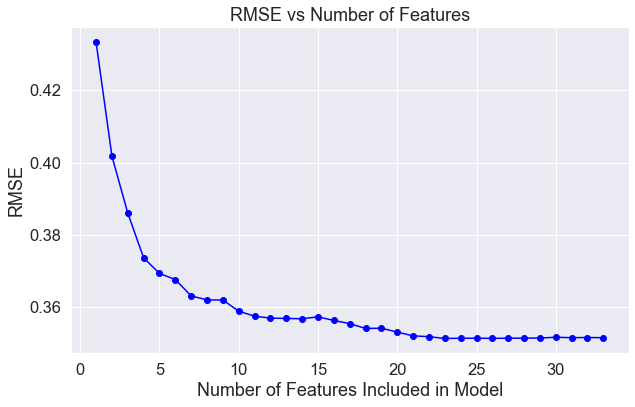

In [73]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(score_board['n_features_to_select'], score_board['test_rmse'], 
        color = 'blue', marker = 'o')
ax.set_xlabel('Number of Features Included in Model')
ax.set_ylabel('RMSE')
ax.set_title('RMSE vs Number of Features')
plt.show()

In [74]:
## From the elbow best features could be 10 ? 
best_features[10]

['Year',
 'Pct_Age<18',
 'Pct_Black',
 'Pct_Hispanic',
 'Potential_Years_Lost',
 'Pct_DUI_Deaths',
 'Pct_Child_in_1ParentHH',
 'Pct_Unemployed',
 'Pct_Poverty',
 'Urbanicity',
 'Prev_Spatial_Mean']

In [77]:
od_nonull = od_nonull.rename(columns={'Pct_Age<18' : 'Pct_Age_18', 'Pct_Age>=65' : 'Pct_Age_65'})

In [85]:
y, X = dmatrices("Overdose_Rate_per_100k ~ Year + Pct_Age_18 + Pct_Black + Pct_Hispanic + Potential_Years_Lost + \
  Pct_DUI_Deaths + Pct_Child_in_1ParentHH + Pct_Unemployed + Pct_Poverty + \
  Urbanicity + Prev_Spatial_Mean",
                 data=od_nonull, return_type='dataframe')

In [86]:
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [87]:
#this is just with the spatial mean component 
mod = sm.OLS(y_train, x_train)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = od_y
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.588
Model:                                OLS   Adj. R-squared:                  0.587
Method:                     Least Squares   F-statistic:                     728.7
Date:                    Fri, 29 Apr 2022   Prob (F-statistic):               0.00
Time:                            12:08:33   Log-Likelihood:                -2175.8
No. Observations:                    5622   AIC:                             4376.
Df Residuals:                        5610   BIC:                             4455.
Df Model:                              11                                         
Covariance Type:                nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [88]:
#this is the 
y_test_pred = res.predict(x_test)
r_squared = r2_score(y_test, y_test_pred)
r_squared

0.5901084200382025

In [89]:
y_test_pred = np.array(y_test_pred)
y_test = np.array(y_test).reshape(1875,1)
y_test_pred = np.array(y_test_pred).reshape(1875,1)
compute_rmse(y_test, y_test_pred)

0.3668238529490423

this RMSE is bigger than the one that was from the other model.... but also doesn't seem to be too far off. There are no insignificant predictors in our model though !!  

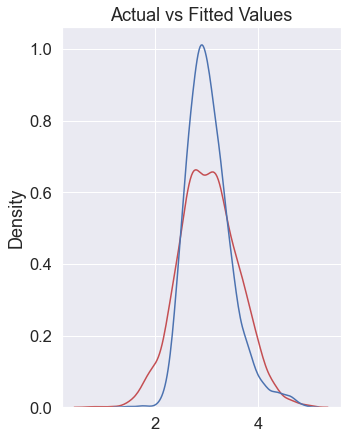

In [90]:
plt.figure(figsize=(5, 7))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_test_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

Now we should plot the residuals!!! 

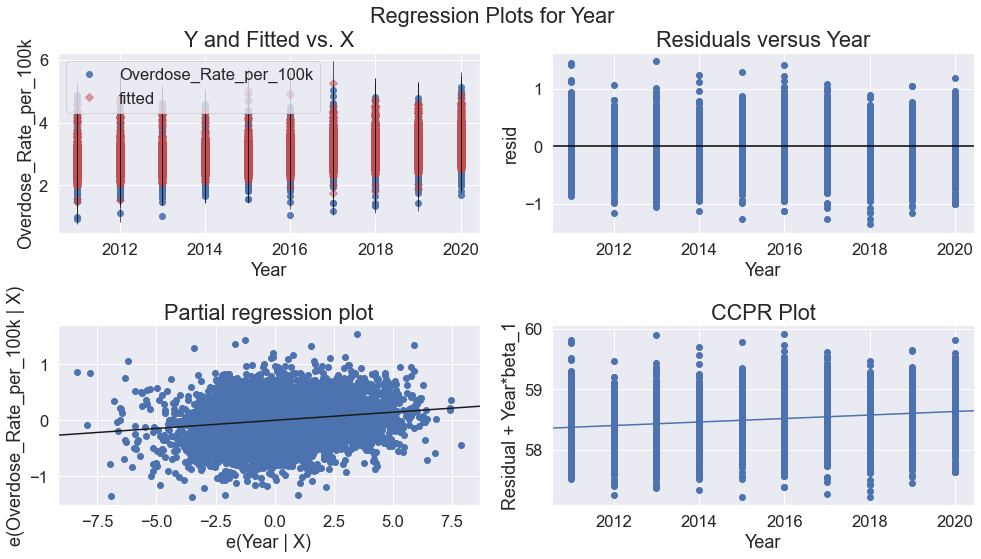

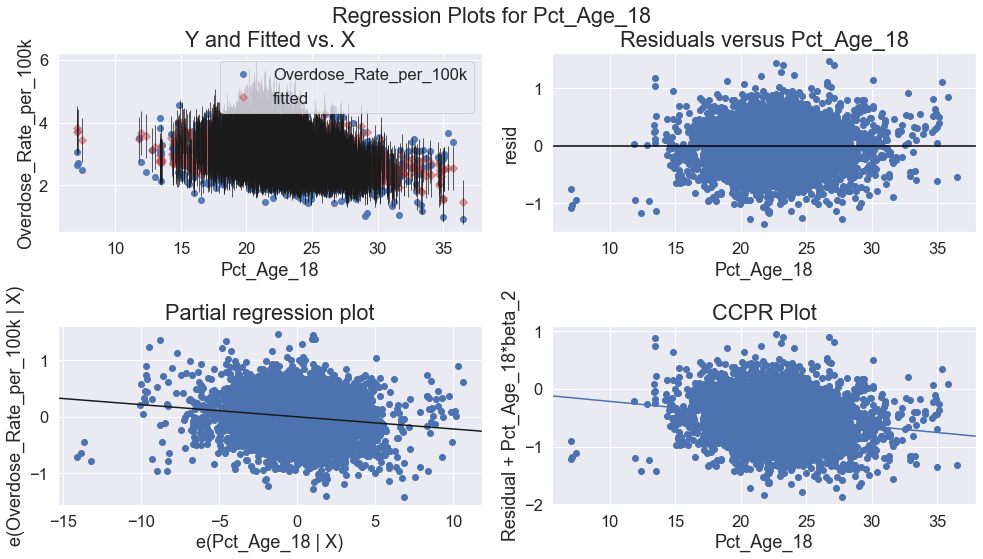

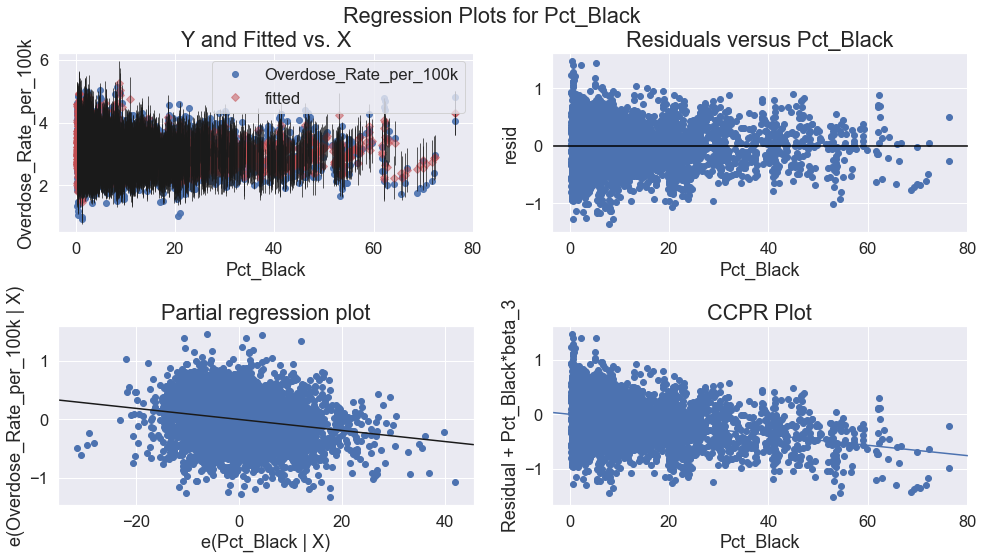

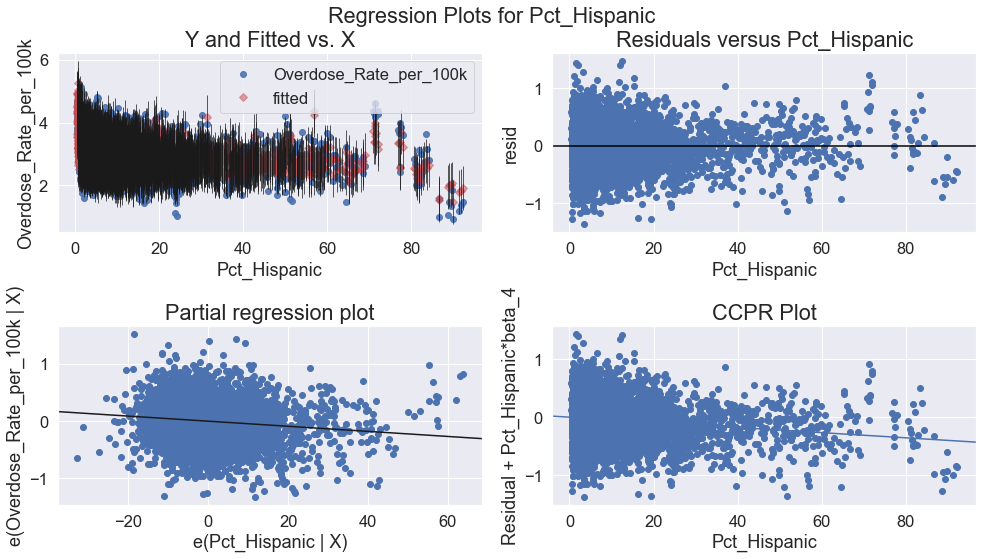

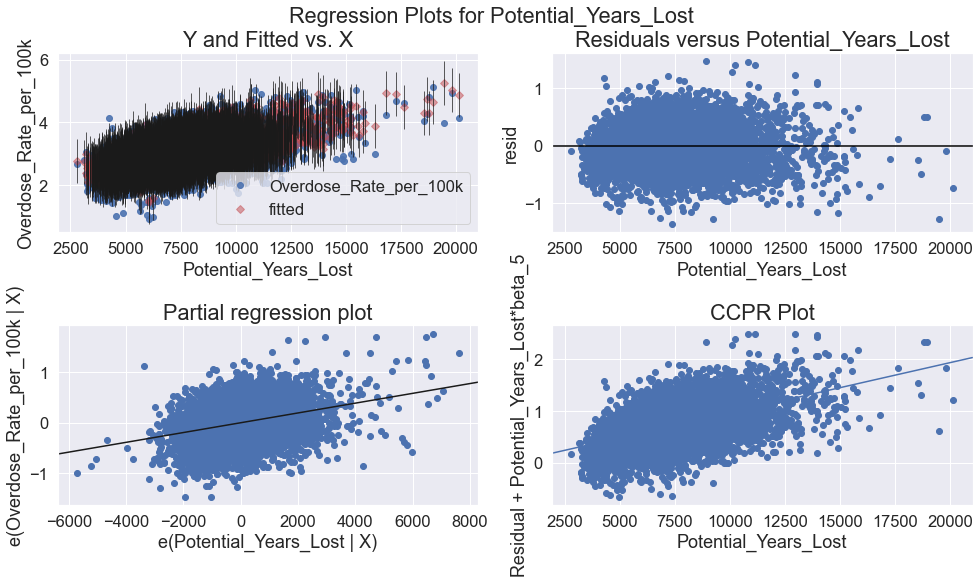

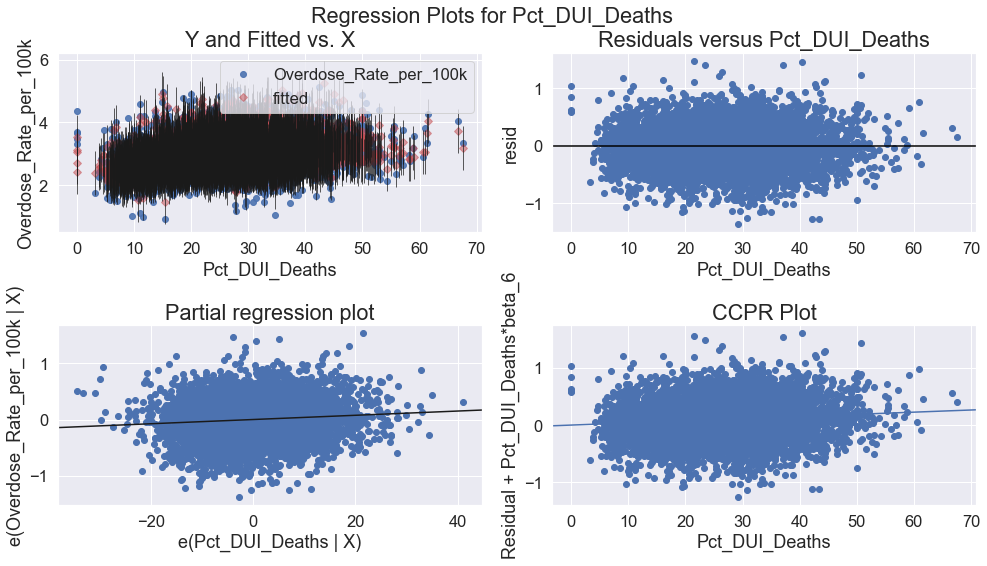

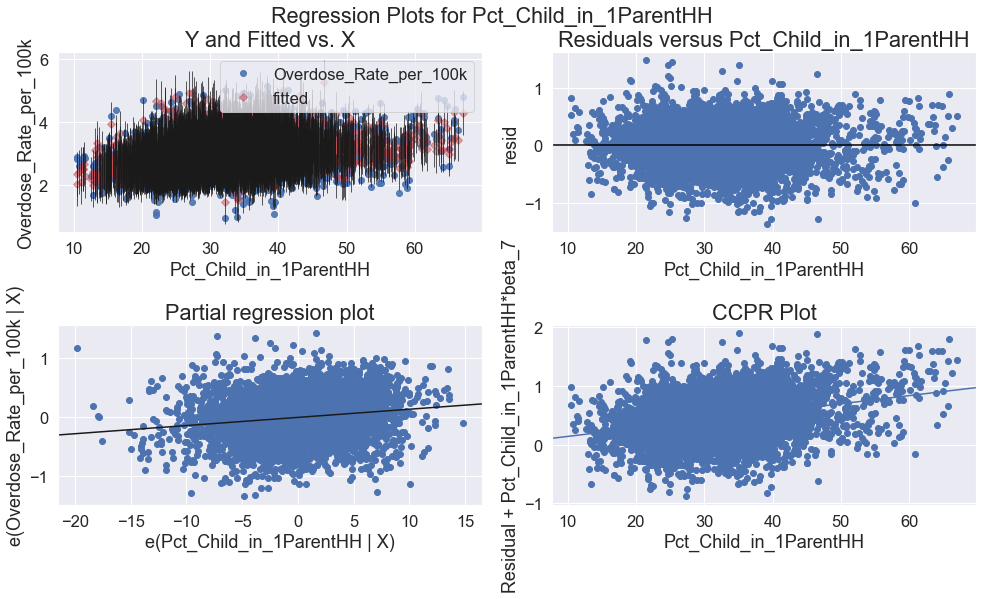

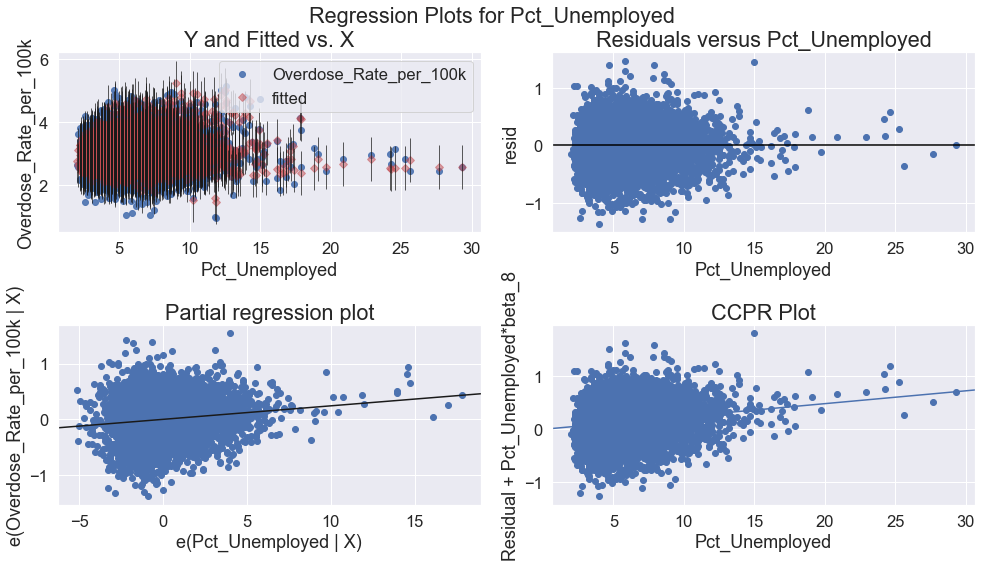

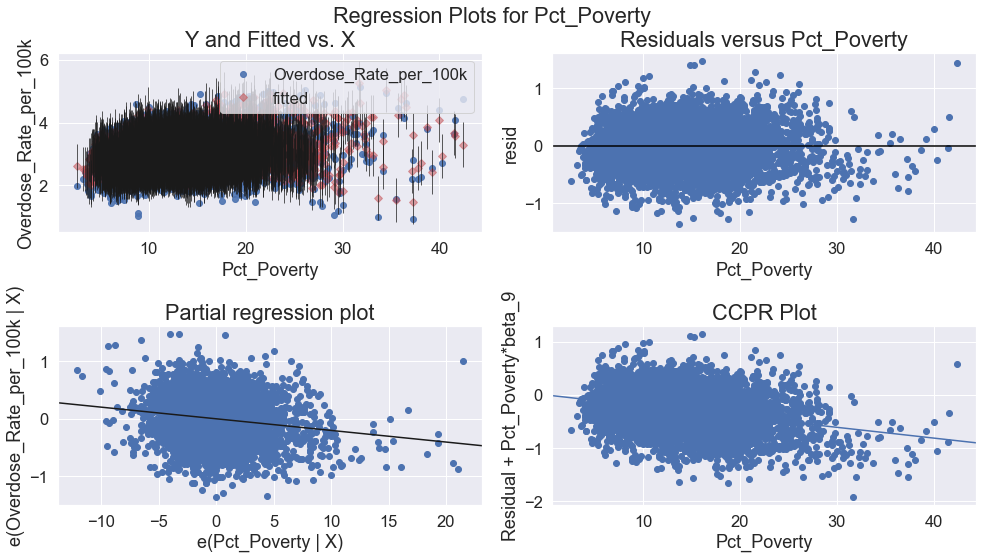

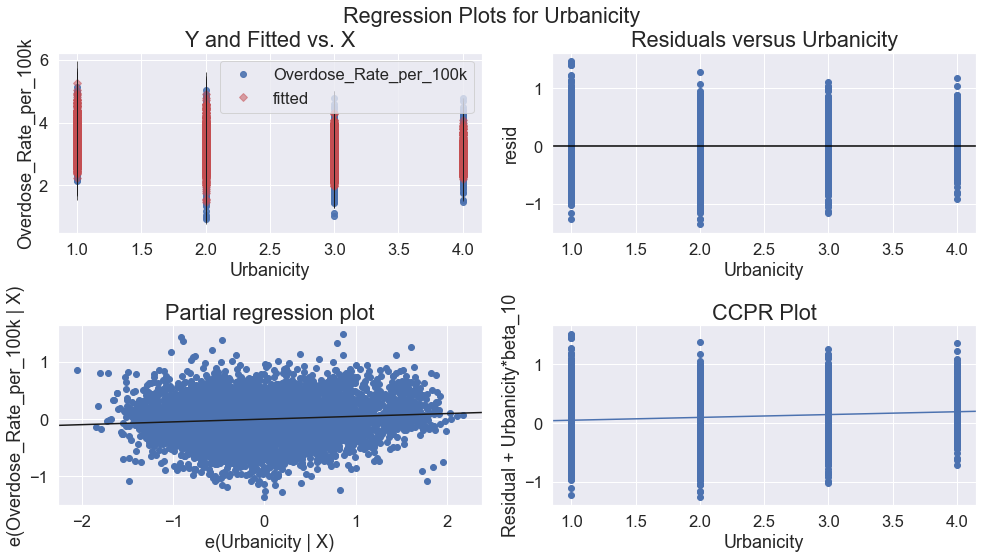

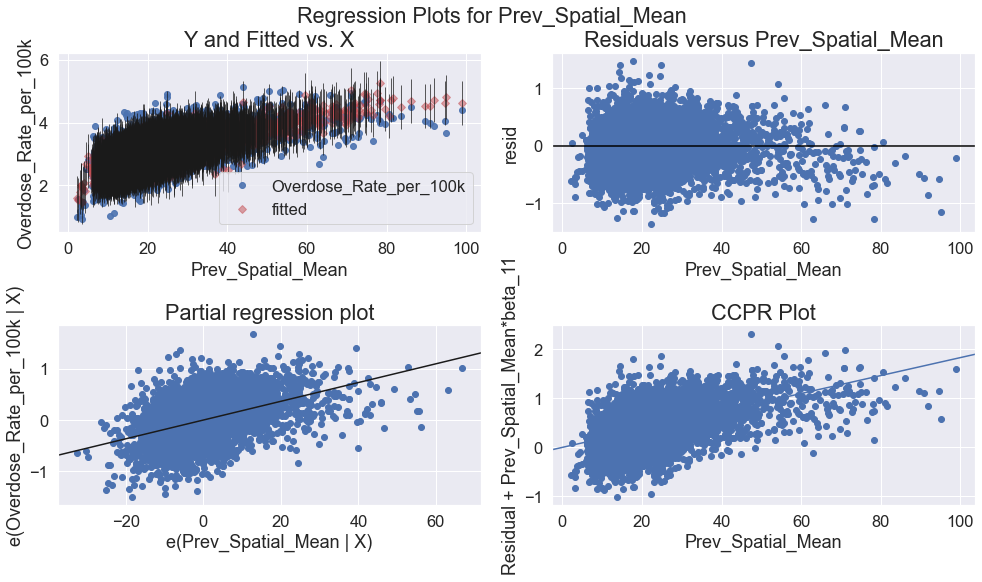

In [93]:
### Residual analysis with best subset 
# plot residuals
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

best_sub = ['Year',
 'Pct_Age_18',
 'Pct_Black',
 'Pct_Hispanic',
 'Potential_Years_Lost',
 'Pct_DUI_Deaths',
 'Pct_Child_in_1ParentHH',
 'Pct_Unemployed',
 'Pct_Poverty',
 'Urbanicity',
 'Prev_Spatial_Mean']

for i in best_sub: 
    fig = plt.figure(figsize=(14, 8))
    fig = sm.graphics.plot_regress_exog(res, i,fig=fig)

### We are doing some cross validation with the backwards stepwise seleciton 